In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab_Notebooks_project/a5'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

# Read csv
file_path = 'drive/MyDrive/Colab_Notebooks_project/a5/sc201/datasets/data/legend 3000 NEW.csv'
df = pd.read_csv(file_path)
emotion = df['emotion']
emotion_np = Series.to_numpy(emotion)
emotion_set = set(emotion_np)

# Create a python dict {'emotion': int}
emotion_category = list(emotion_set)
emotion_dict = {}
for i in range(len(emotion_category)):
  emotion_dict[emotion_category[i]] = i

In [5]:
reversed_dataset = {}
for e in emotion_dict:
  reversed_dataset[emotion_dict[e]] = e

In [ ]:
import os

file = Series.to_numpy(df["image"])
file = [i for i in file]
file = [os.path.join("drive/MyDrive/Colab_Notebooks_project/a5/sc201/datasets/images", i) for i in file]
file_train = file[:2700]
file_test = file[2700:]
# real_file_test = file[2000:]

np.save("file_train.npy", file_train)
np.save("file_test.npy", file_test)
# np.save("real_file_test.npy", real_file_test)

In [6]:
emotion = Series.to_numpy(df["emotion"])
emotion_lst = list(emotion)
data_number = len(emotion_lst)

number = []
for i in range(data_number):
  number.append(emotion_dict[emotion_lst[i]])
number = np.array(number) 
number_train = number[:2700]
number_test = number[2700:]
# real_number_test = number[2000:]

np.save("number_train.npy", number_train)
np.save("number_test.npy", number_test)
# np.save("real_number_test.npy", real_number_test)

In [ ]:
from PIL import Image
# Build a link to connect with data and preprocessing.
preprocess = T.Compose([T.ToTensor(), T.Normalize(mean=[0.5], std=[0.5])])

def default_loader(path):
  img = Image.open(path).convert('L')   # open img and turn it to grayscale
  img = img.resize((300, 300))
  img_tensor = preprocess(img)
  return img_tensor


class Dataset(Dataset):
  def __init__(self, fileset, numberset, loader=default_loader):
    self.images = fileset
    self.target = numberset
    self.loader = loader

  def __getitem__(self, index):
    fn = self.images[index]
    img = self.loader(fn)
    target = self.target[index]
    return img, target

  def __len__(self):
    return len(self.images)

In [ ]:
# Create a trainset data, valset data, and testset data.
NUM_TRAIN = len(number_train) -300
emotion_train = Dataset(file_train, number_train)
loader_train = DataLoader(emotion_train, batch_size=24,                         # len: 1000
                     sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(emotion_train, batch_size=24,                           # len: 500
                   sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(number_train))))

emotion_test = Dataset(file_test, number_test)
loader_test = DataLoader(emotion_test)                           # len: 500


# real_test = Dataset(real_file_test, real_number_test)
# real_loader_test = DataLoader(real_test)

In [ ]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 10

print('using device:', device)

using device: cuda


In [ ]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1) 

In [ ]:
def check_accuracy_part34(loader, model): 
    num_correct = 0
    num_samples = 0
    correct_lst = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)

            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            correct_lst.append((x, y, preds))
            # for i in range(len(preds)):
            #   if preds[i] == y[i]:
            #     correct_lst.append((x, y, preds))

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

    return correct_lst

In [ ]:
def train_part34(model, optimizer, epochs=1):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print('epochs %d' % e)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = nn.functional.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy_part34(loader_val, model)
                print()
        print('')

In [ ]:
class Conv_FC_Layers(nn.Module):
  def __init__(self, input_channel, channel_1, channel_2, channel_3, fc1_neurons, fc2_neurons, num_classes):
      super().__init__()
      self.conv1 = nn.Sequential(nn.Conv2d(input_channel, channel_1, (3, 3), padding=1), nn.ReLU(), nn.Conv2d(channel_1, channel_2, (3, 3), padding=1), nn.ReLU())
      
      self.conv2 = nn.Sequential(nn.Conv2d(channel_2, channel_2, (3, 3), padding=1), nn.ReLU(), nn.Conv2d(channel_2, channel_3, (3, 3), padding=1), nn.ReLU())

      self.pooling = nn.MaxPool2d(2, stride=2)

      self.fc1 = nn.Sequential(nn.Linear(channel_3*75*75, fc1_neurons), nn.Dropout(p=0.4), nn.Linear(fc1_neurons, fc2_neurons))

      self.fc2 = nn.Linear(fc2_neurons, num_classes, nn.Softmax())


  def forward(self, x):
      x = self.pooling(self.conv2(self.pooling(self.conv1(x))))
      scores = self.fc2(self.fc1(flatten(x)))
      return scores

In [ ]:
input_channel = 1
channel_1 = 64
channel_2 = 128
channel_3 = 256
fc1_neurons = 50
fc2_neurons = 30
num_classes = 8
learning_rate = 5e-3


model = Conv_FC_Layers(input_channel, channel_1, channel_2, channel_3, fc1_neurons, fc2_neurons, num_classes)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
train_part34(model, optimizer, epochs=10)

epochs 0
Iteration 0, loss = 2.0286
Got 55 / 300 correct (18.33)

Iteration 10, loss = 1.5496
Got 242 / 300 correct (80.67)

Iteration 20, loss = 1.7682
Got 242 / 300 correct (80.67)

Iteration 30, loss = 1.7258
Got 228 / 300 correct (76.00)

Iteration 40, loss = 1.4799
Got 214 / 300 correct (71.33)

Iteration 50, loss = 1.6992
Got 213 / 300 correct (71.00)

Iteration 60, loss = 1.4440
Got 214 / 300 correct (71.33)

Iteration 70, loss = 1.5586
Got 234 / 300 correct (78.00)

Iteration 80, loss = 1.3723
Got 223 / 300 correct (74.33)

Iteration 90, loss = 1.0364
Got 220 / 300 correct (73.33)


epochs 1
Iteration 0, loss = 1.6256
Got 195 / 300 correct (65.00)

Iteration 10, loss = 1.3778
Got 137 / 300 correct (45.67)

Iteration 20, loss = 1.2010
Got 194 / 300 correct (64.67)

Iteration 30, loss = 1.4755
Got 190 / 300 correct (63.33)

Iteration 40, loss = 1.3064
Got 139 / 300 correct (46.33)

Iteration 50, loss = 1.2835
Got 190 / 300 correct (63.33)

Iteration 60, loss = 1.0087
Got 220 / 30

In [ ]:
best_model = model
acc = check_accuracy_part34(loader_test, best_model)

# x_lst = list(acc[i][0] for i in range(len(acc)))
# y_lst = list(int(acc[i][1]) for i in range(len(acc)))
# preds_lst = list(int(acc[i][2]) for i in range(len(acc)))

# print(emotion_dict)
# print(y_lst)
# print(preds_lst)

Got 162 / 300 correct (54.00)


In [ ]:
# Read csv
test_file_path = 'drive/MyDrive/Colab_Notebooks_project/a5/sc201/datasets/data/test_data_IRL.csv'
df_test = pd.read_csv(test_file_path)

IRL_file = Series.to_numpy(df_test["image"])
IRL_file = [i for i in IRL_file]
IRL_file = [os.path.join("drive/MyDrive/Colab_Notebooks_project/a5/sc201/datasets/images", i) for i in IRL_file]
np.save("IRL_file.npy", IRL_file)

test_emotion = Series.to_numpy(df_test["emotion"])
test_emotion_lst = list(test_emotion)
label_number = len(test_emotion_lst)
test_number_lst = []
for i in range(label_number):
  test_number_lst.append(emotion_dict[test_emotion_lst[i]])
IRL_number = np.array(test_number_lst)
np.save("IRL_number.npy", IRL_number)

In [ ]:
test = Dataset(IRL_file, IRL_number)
test_loader = DataLoader(test)

In [ ]:
best_model = model
acc_test = check_accuracy_part34(test_loader, best_model)
x_lst = list(acc_test[i][0] for i in range(len(acc_test)))
y_lst = list(int(acc_test[i][1]) for i in range(len(acc_test)))
preds_lst = list(int(acc_test[i][2]) for i in range(len(acc_test)))

img_lst = []
for i in range(len(x_lst)):
  input_tensor = torch.reshape(x_lst[i], (1, 300, 300))
  new_img = T.ToPILImage()(input_tensor).convert('L')
  img_lst.append((new_img, y_lst[i], preds_lst[i]))

Got 2 / 8 correct (25.00)


Prediction: sadness
True label: surprise


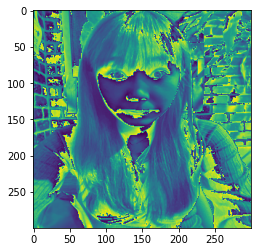

In [ ]:
prediction = reversed_dataset[img_lst[0][2]]
true_label = reversed_dataset[img_lst[0][1]]

plt.imshow(img_lst[0][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: sadness
True label: fear


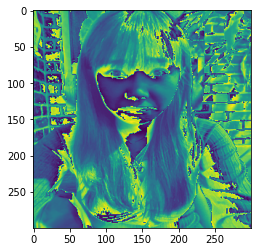

In [ ]:
prediction = reversed_dataset[img_lst[1][2]]
true_label = reversed_dataset[img_lst[1][1]]

plt.imshow(img_lst[1][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: sadness
True label: contempt


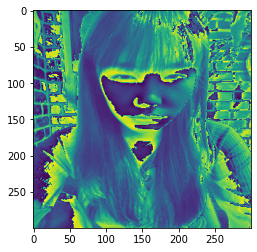

In [ ]:
prediction = reversed_dataset[img_lst[2][2]]
true_label = reversed_dataset[img_lst[2][1]]

plt.imshow(img_lst[2][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: sadness
True label: sadness


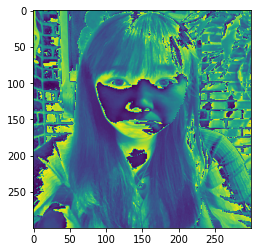

In [ ]:
prediction = reversed_dataset[img_lst[3][2]]
true_label = reversed_dataset[img_lst[3][1]]

plt.imshow(img_lst[3][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: sadness
True label: disgust


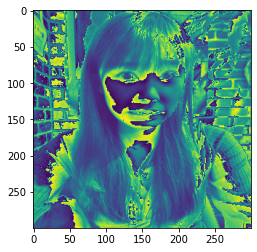

In [ ]:
prediction = reversed_dataset[img_lst[4][2]]
true_label = reversed_dataset[img_lst[4][1]]

plt.imshow(img_lst[4][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: sadness
True label: neutral


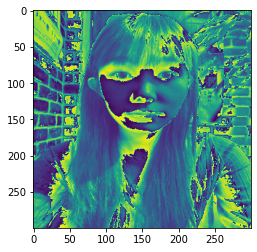

In [ ]:
prediction = reversed_dataset[img_lst[5][2]]
true_label = reversed_dataset[img_lst[5][1]]

plt.imshow(img_lst[5][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: disgust
True label: happiness


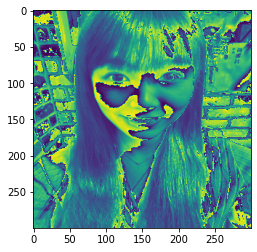

In [ ]:
prediction = reversed_dataset[img_lst[6][2]]
true_label = reversed_dataset[img_lst[6][1]]

plt.imshow(img_lst[6][0])
print('Prediction:', prediction)
print('True label:', true_label)

Prediction: anger
True label: anger


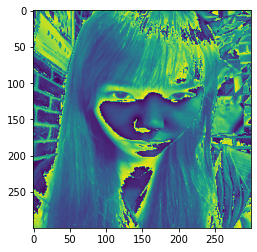

In [ ]:
prediction = reversed_dataset[img_lst[7][2]]
true_label = reversed_dataset[img_lst[7][1]]

plt.imshow(img_lst[7][0])
print('Prediction:', prediction)
print('True label:', true_label)